<a href="https://colab.research.google.com/github/Ryukijano/-Transformers-/blob/main/mask_former_hf_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing necessary libraries

!pip install datasets -qq
!pip install evaluate -qq
!pip install albumentations -qq
!pip install git+https://github.com/huggingface/transformers.git -qq

#for uploading model into hugging_face_hub
!pip install huggingface_hub -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 4

In [ ]:
#importing libaries
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader

import albumentations as A 

import numpy as np 
import pandas as pd

from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)

import evaluate
from huggingface_hub import notebook_login

In [ ]:
'''
We are using the ADE20K dataset, consisting of over 20k images and their segmentation annotations. Named after Adela Burriuso, who single handedly annoted the dataset.
ADE20K is among the most popular and widely used semantic segmentation datasets. 
The Scene Parsing dataset has 150 semantic labels for the semantic segmentation task and 100 for the instance segmentation task.
'''
#loading the dataset using HF libraries

train = load_dataset("scene_parse_150", "instance_segmentation", split="train")
validation = load_dataset("scene_parse_150", "instance_segmentation", split="validation")
test = load_dataset("scene_parse_150", "instance_segmentation", split="test")



Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset scene_parse_150 downloaded and prepared to /root/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75. Subsequent calls will reuse this data.


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F14E9820DF0>, 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F14E9F9E430>}
[Info] Displaying a random image and its annotation...


(-0.5, 438.5, 599.5, -0.5)

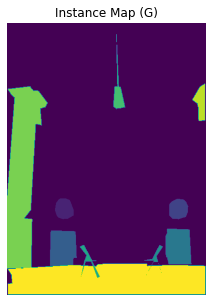

In [ ]:
#exploring the dataset
print(train[0])
#grabbing a random index of the training dataset
print("[Info] Displaying a random image and its annotation...")
index = random.randint(0, len(train))

#using the random index grabbing the corresponding datapoint
#from the training datset
image = train[index]["image"]
image = np.array(image.convert("RGB"))
annotation = train[index]["annotation"]
annotation = np.array(annotation)

#plotting the original image and the annotations
plt.figure(figsize=(15,5))
for plot_index in range(3):
  if plot_index == 0:
    #if plot_index is 0, we display the original image
    plot_image = image
    title = "Original"
  else:
    #else plot the annotation maps
    plot_image = annotation[..., plot_index - 1]
    title = ["Class Map (R)","Instance Map (G)"][plot_index - 1]

#plotting the image
plt.subplot(1,3, plot_index + 1)
plt.imshow(plot_image)
plt.title(title)
plt.axis("off")

#Instance Segmentation Annotations

We look at instance segmentation annotations. As described in the Scene Parsing dataset page, [link text](https://huggingface.co/datasets/scene_parse_150) the instance annotation masks are stored in RGB image format and structured as follows:

The R(ed) channel encodes category ID.
The G(reen) channel encodes instance ID.
Instance IDs are assigned per image such that each object in an annotation image has a different instance ID (regardless of its class ID). In contrast, different annotation images can have objects with the same instance ID. Each image in the dataset has < 256 object instances.
We can refer to this file [link text](https://github.com/CSAILVision/placeschallenge/blob/master/instancesegmentation/instanceInfo100_train.txt) (train split) for the 100 class labels included in the instance segmentation subset of Scene Parsing.

Semantic and instance segmentation subsets of Scene Parsing don’t have the same id2label mapping. To find the mapping between the semantic categories for instance_segmentation and semantic_segmentation and the ADE20K dataset, we need to refer to Mapping.txt.



Preprocessing the Dataset
For any 🤗 Transformers vision model, we can simply use the corresponding FeatureExtractor or ImageProcessor class to preprocess raw images (and segmentation maps) and convert them to the format expected by the model.

As Scene Parsing is a large image dataset, we will call the preprocessor as we iterate over the training and validation loops instead of preprocessing all data at once.

FeatureExtractor and ImageProcessor Classes
Each model on the 🤗 Hub has a corresponding FeatureExtractor or ImageProcessor or Processor (for multi-modal models) class that is used to preprocess the raw image (or text, speech, etc.) such that it has the expected input shape and format used by the model. Some classes also include convenient post-processing methods to convert raw model outputs to final predictions.

Same as the Model and Config class, we can use the from_pretrained() method to retrieve the processor of any pre-trained model.



In [ ]:
'''
from transformers import XXXModelImageProcessor

# Use default configuration
preprocessor = XXXModelImageProcessor.from_pretrained(<MODEL_NAME>)

train = load_dataset(<DATASET>)["train"]
for data in train:
    model = XXXModelImageProcessor(data[<target_key>])
'''

'\nfrom transformers import XXXModelImageProcessor\n\n# Use default configuration\npreprocessor = XXXModelImageProcessor.from_pretrained(<MODEL_NAME>)\n\ntrain = load_dataset(<DATASET>)["train"]\nfor data in train:\n    model = XXXModelImageProcessor(data[<target_key>])\n'

#Defining a Preprocessor Configuration

An important point to note here is that the preprocessor configuration needs to be consistent with the model configuration chosen for the input data to be preprocessed correctly (e.g., expected image size, normalization, augmentation, …).

As there are no model checkpoints available on the hub that were trained on the Scene Parsing dataset, we will create our custom preprocessor configuration.

In [ ]:
#Creating the MaskFormer Image Preprocessor
processor = MaskFormerImageProcessor(
    reduce_labels=True,
    size=(512, 512),
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)


/usr/local/lib/python3.9/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
#setting config
config = MaskFormerConfig()
config.embed_dim = 256 #editing the configuration 

In [ ]:
#defining the name of the model and printing out the config
from transformers import MaskFormerConfig 
config = MaskFormerConfig.from_pretrained("facebook/maskformer-swin-base-coco")
config

MaskFormerConfig {
  "_commit_hash": "6628e1a5bf23dd6666edd1f0867e46458a94706c",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 128,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 1024

In [ ]:
#defining the name of the model
model_name = "facebook/maskformer-swin-base-ade"
#Getting the maskformer config and printing it
config = MaskFormerConfig.from_pretrained(model_name)
print("[INFO] displaying the MaskFormer configuration....")
print(config)

[INFO] displaying the MaskFormer configuration....
MaskFormerConfig {
  "_commit_hash": "b569351e060953d37fd7dfb8b16ab83c360a13d6",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 128,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    

In [ ]:
#downloading the SceneParsing instance segmentation labels
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt

--2023-03-23 17:04:18--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [text/plain]
Saving to: ‘instanceInfo100_train.txt’

instanceInfo100_tra 100%[===================>]   3.24K  --.-KB/s    in 0s      

2023-03-23 17:04:19 (50.9 MB/s) - ‘instanceInfo100_train.txt’ saved [3313/3313]



In [ ]:
#Get a modified version of the id2label and label2id
data = pd.read_csv(
    "/content/instanceInfo100_train.txt",
    sep="\t",
    header=0,
    on_bad_lines="skip",
)
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
label2id = {v: k for k, v in id2label.items()}

#Editing MaskFormer config labels
config.id2label = id2label
config.label2id = label2id

In [ ]:
#Use the config object to initialize a MaskFormer model with randomized weights
model = MaskFormerForInstanceSegmentation(config)

#Replace the randomly intialized model with the pre-trained model weights 
base_model = MaskFormerModel.from_pretrained(model_name)
model.model = base_model

Some weights of the model checkpoint at facebook/maskformer-swin-base-ade were not used when initializing MaskFormerModel: ['mask_embedder.2.0.weight', 'mask_embedder.2.0.bias', 'class_predictor.weight', 'mask_embedder.1.0.weight', 'mask_embedder.0.0.weight', 'mask_embedder.0.0.bias', 'class_predictor.bias', 'criterion.empty_weight', 'mask_embedder.1.0.bias']
- This IS expected if you are initializing MaskFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MaskFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Define the configurations of the transforms specific to the dataset used
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

#Build the augmentation transforms
train_val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

class ImageSegmentationDataset(Dataset):
  def __init__(self, dataset, processor, transform=None):
    #Initialize the dataset, processor, and transform variables
    self.dataset = dataset
    self.processor = processor
    self.transform = transform

  def __len__(self):
    #returing the number of datapoints
    return len(self.dataset)
  
  def __getitem__(self, idx):
    #convert the PIL Image to a NumPy array
    image = np.array(self.dataset[idx]["image"].convert("RGB"))

    #getting pixel wise instance id and category id maps of shape (height, width)
    instance_seg = np.array(self.dataset[idx]["annotation"])[..., 1]
    class_id_map = np.array(self.dataset[idx])["annotation"])[..., 0]
    class_labels = np.unique(class_id_map)

    #building the instance to class dictionary
    inst2class = {}
    for label in class_labels:
      instances_ids = np.unique(instance_seq[class_id_map == label])
      inst2class.update({i: label for i in instance_ids})
    
    #appying transforms
    if self.transform is not None:
      transformed = self.transform(image=image, mask=instance_seg)
      (image, instance_seg) = (transformed["image"], transformed["mask"])

      #converting from channels last to channels first
      image = image.transpose(2,0,1)

    if class_labels.shape[0] == 1 and class_labels[0] == 0:
      #if the image has no objects then it is skipped
      inputs = self.processor([image], return_tensors="pt")
      inputs = {k:v.squeeze() for k,v in inputs.items()}
      inputs["class_labels"] = torch.tensor([0])
      inputs["mask_labels"] = torch.zeros(
          (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
      )
    else:
      #Else we process the image with segmentation maps
      inputs = self.processor(
          [image],
          [instance_seg],
          instance_id_to_semantic_id=inst2class,
          return_tensors="pt"
      )
      inputs = {
          k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
      }
    
    #returning the inputs
    return inputs

#Build the train and validation instance segmentation dataset
train_dataset = ImageSegmentationDataset(
    train,
    processor=processor,
    transform=train_val_transform
)
 






In [ ]:
#checking if everything is preprocessed correctly
input = val_dataset[0]
for k,v in inputs.items():
  print(k, v.shape)
  


In [ ]:
#creating a collate function to load the data in batches

def collate_fn(examples):
  #getting pixel vales, pixel mask, mask labels and class labels
  pixel_values = torch.stack([example["pixel_value"]]) for examples])
  pixel_mask = torch.stack([example["pixel_mask"] for example in examples])
  mask_labels = [example["mask_labels"] for example in examples]
  class_labels = [example["class_labels"] for example in examples]

  #returning a dictionary of all collated features 
  return {
      "pixel_values": pixel_values,
      "pixel_mask": pixel_mask,
      "mask_labels": mask_labels,
      "class_labels": class_labels
  }

# building the training and validation dataloader
train_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
) 


In [ ]:
#training step
#using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#initializing adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

#setting number of epochs and batch size
num_epochs = 2

for epoch in range(num_epochs):
  print(f"Epoch{epoch} | Training")
  #setting the model in training mode
  model.train()
  train_loss, val_loss = [], []
  #training loop
  for idx, batch in enumerate(tqdm(train_dataloader)):
    #reset the parameter gradients
    optimizer.zero_grad()

    #forward pass
    outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
    )
    #backward propagation
    loss = outputs.loss
    train_loss.append(loss.item())
    loss.backward()

    if idx % 50 == 0:
      print("Training loss: ", round(sum(train_loss)/len(train_loss), 6))
    #optimization
    optimizer.step()
  #average train epoch loss
  train_loss = sum(train_loss)/len(train_loss)
  #setting the model in evaluation mode
  model.eval()
  
  start_idx = 0
  print(f"Epoch {epoch} | Validation")
  for idx, batch in enumerate(tqdm(val_dataloader)):
    with torch.no_grad():
      #forward pass
      outputs = model(
          pixel_values = batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      #getting validation loss
      loss = outputs.loss
      val_loss.append(loss.item())

      if idx % 50 == 0:
        print(" Validation loss :", round(sum(val_loss)/len(val_loss), 6))
  
  #average validation epoch loss
  val_loss = sum(val_loss)/len(val_loss)
  #print epoch losses
  print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")
  

#Saving the Trained Model
Luckily for us, 🤗 Transformers make it really easy to save trained models and custom preprocessing pipelines. We can simply call the save_pretrained() method as follows:

model.save_pretrained(<Path to target save folder>)

preprocessor.save_pretrained(<Path to target save folder>)



In [ ]:
from huggingface_hub import notebook_login

In [ ]:
#pushing it to the hub
#logging into hf
notebook_login()

#we wont be using albumentations to preprocess images for inference
processor.do_normalize = True
processor.do_resize = True
processor.do_rescale = True

#pushing model and preprocessor to HUB
model.push_to_hub("maskformer-swin-base-sceneparse-instance")
processor.push_to_hub("maskformer-swin-base-sceneparse-instance")



In [ ]:
#using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#grabbing the trained model and processor from the hub
model = MaskFormerForSegmentation.from_pretrained("
").to(device)
processor = MaskFormerImageProcessor.from_pretrained("")

In [ ]:
#use random test image
index = random.randint(0, len(test))
image = test[index]["image"].convert("RGB")
target_size = image.size[::-1]



In [ ]:
#preprocess image
inputs = processor(image=image, return_tensors="pt").to(device)

#inference
model.eval()
with torch.no_grad():
  outputs = model(**inputs)
#printing the items returned by our model and their shapes 
print("Outputs...")
for key, value in outputs.items():
  print(f" {key}: {value.shape}")

##Post-Processing Outputs

As we can see, MaskFormer returns class query logits of shape (batch_size, num_queries, num_labels + 1) and mask query logits of shape (batch_size, num_queries, height, width). Therefore, to retrieve the most probable instance segmentation masks and their classes and to rescale them back to the original image/s shape, we can use the convenient post_process_instance_segmentation() method of the MaskFormerImageProcessor class.

Note that this class also has post_process_semantic_segmentation() and post_process_panoptic_segmentation() methods to post-process the outputs of MaskFormer models trained on semantic segmentation and panoptic segmentation datasets. If in doubt, refer to the model card of the checkpoint you would like to use to find out which dataset your selected model was trained on.

Let’s post-process our segmentation predictions and see what this method outputs:

In [ ]:
#post-process results to retrieve instance segmentation maps
result = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    target_sizes=[target_size]
)[0] #we pass a single output therefore we take the first result(single)

instance_seg_mask = result["segmentation"].cpu().detach().numpy()

print(f"Final mask shape: {instance_seg_mask.shape}")
print("Segments Information..")
for info in result["segments_info"]:
  print(f" {info}")


The MaskFormerImageProcessor.post_process_instance_segmentation() returns a list of length batch_size where each entry is a dictionary and contains two keys:

segmentation: A tensor of shape (height, width) where each pixel represents an instance id or List[List] run-length encoding (RLE) of the segmentation map if return_coco_annotation is set to True or a concatenated tensor of binary segmentation maps (one per detected instance) of shape (num_instances, height, width) if return_binary_maps is set to True.

segments_info: A dictionary that contains additional information on each segment.

id: An integer representing the instance id.

label_id: An integer representing the semantic class id corresponding to id.

score: Prediction score of a segment with id.

In [ ]:
def visualize_instance_seg_mask(mask):
  #initializing image with zeros with the image resolution of the segmentation mask and 3 channels.
  image = np.zeros((mask.shape[0], mask.shape[1], 3))

  #creating labels
  labels = np.unique(mask)
  label2color = {
      label: (
          random.randint(0, 255),
          random.randint(0, 255),
          random.randint(0, 255),
      )
      for label in labels
  }

  for height in range(image.shape[0]):
    for width in range(image.shape[1]):
      image[height, width, :] = label2color[mask[height, width]]

  image = image / 255
  return image

instance_seq_mask_disp = visualize_instance_seg_mask(instance_seg_mask)

plt.figure(figsize=(10, 10))
for plot_index in range(2):
  if plot_index == 0:
    plot_image = image
    title = "Original"
  else:
    plot_image = instance_seg_mask_disp
    title = "Segementation"

  plt.subplot(1,2, plot_index+1)
  plt.imshow(plot_image)
  plt.title(title)
  plt.axis("off")


In [ ]:
#performance evaluation

#load mean IoU Metric
metrics = evaluate.load("mean_iou")

#set model in evaluation mode
model.eval()

#test set doesn't have annotations so we will use the validation set
ground_truths, preds = [], []

for idx in tqdm(range(200)):
  image = validation[idx]["image"].convert("RGB")
  target_size = image.size[::-1]

  #getting ground truth semantc segmentation map
  annotation = np.array(validation[idx]["annotation"]) [:,:,0]
  #replacing null class (0) with the ignore_index (255) and reduce labels
  annotation -= 1
  annotation[annotation==-1] = 255
  ground_truths.append(annotation)

  #preprocessing images
  inputs = processor(images=image, return_tensors="pt").to(device)

  #inferencing
  model.eval()
  with torch.no_grad():
    outputs = model(**inputs)

  #post processing results to retrieve semantic segmentation maps
  result = processor.post_process_semantic_segmentation(outputs, target_sizes=[target_size])[0]
  semantic_seg_mask = result.cpu().detach().numpy()
  preds.append(semantic_seg_mask)

results = metrics.compute(
    predictions=preds,
    references=ground_truths,
    num_labels=100,
    ignore_index=255
)
print(f"Mean IoU: {results['mean_iou']} | Mean Accuracy: {results['mean_accuracy']} | Overall Accuracy: {results['overall_accuracy']}")

